<b><h1>Тема научной работы: Изучение методов анализа данных на примере задачи гендерной классификации банковских транзакций</h1></b>

<h2>Анализ данных и feature extraction</h2>

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
warnings.simplefilter('ignore')

transactions = pd.read_csv('transactions.csv')
tr_types = pd.read_csv('tr_types.csv')
customers_gender_train = pd.read_csv('customers_gender_train.csv')
codes = pd.read_csv('tr_mcc_codes.csv', sep='delimiter', header=None)


<p>Приводим таблицу с типами учреждений к удобоваримому виду</p>

In [3]:
codes = codes[1:]
codes['mcc_code'] = codes[0].apply(lambda s : int(s.split(';')[0]))
codes['mcc_description'] = codes[0].apply(lambda s : s.split(';')[1])
codes.head()

,0,mcc_code,mcc_description
1,742;Ветеринарные услуги,742,Ветеринарные услуги
2,"1711;Генеральные подрядчики по вентиляции, теп...",1711,"Генеральные подрядчики по вентиляции, теплосна..."
3,1731;Подрядчики по электричеству,1731,Подрядчики по электричеству
4,"1799;Подрядчики, специализированная торговля —...",1799,"Подрядчики, специализированная торговля — нигд..."
5,2741;Разнообразные издательства/печатное дело,2741,Разнообразные издательства/печатное дело


<p>Таблица с пользователями</p>

In [4]:
customers_gender_train.head()

,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


<p>Таблица с транзакциями</p>

In [6]:
transactions.head()


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


Приводим таблицу с типами транзакций к нормальному виду

In [7]:
types_copy = tr_types
types_copy['tr_type'] = types_copy['tr_type;tr_description'].apply(lambda s: int(s.split(';')[0]))
types_copy['tr_description'] = types_copy['tr_type;tr_description'].apply(lambda s: s.split(';')[1])
types_copy.head()

,tr_type;tr_description,tr_type,tr_description
0,3200;Плата за предоставление услуг посредством...,3200,Плата за предоставление услуг посредством моби...
1,3210;Плата за предоставление отчета по счету к...,3210,Плата за предоставление отчета по счету карты ...
2,3800;Плата за обслуживание банковской карты (з...,3800,Плата за обслуживание банковской карты (за пер...
3,4000;Плата за получение наличных в Сбербанке,4000,Плата за получение наличных в Сбербанке
4,4001;Плата за получение наличных в Сбербанке (...,4001,Плата за получение наличных в Сбербанке (в дру...


Объединяем все таблицы в одну

In [8]:
res = transactions.merge(customers_gender_train, on = 'customer_id')
res = res.merge(types_copy, 'left', on = 'tr_type')
res = res.merge(codes, 'left', on = 'mcc_code')
res = res.drop('tr_type;tr_description',1)
res = res.drop(0,1)
res = res[res['tr_type'] != 999999]
types_copy = types_copy[types_copy['tr_type'] != 999999] 




In [10]:
res.head()


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,mcc_description
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих..."
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,Списание с карты по операции “перевода с карты...,Денежные переводы
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ..."
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ..."


In [11]:
res['gender'].value_counts() #0 - женщина, 1 - мужчина (видно по количеству транзакций в парикмахерских)

0    2845334
1    2548003
Name: gender, dtype: int64

Выделяем из datetime день недели, попутно очищая от строк, где время не определено

In [12]:
res_copy = res
res_copy['tr_datetime'].unique
res_copy = res_copy[res_copy['tr_datetime'].notnull()]
res_copy['tr_datetime'].unique
res = res_copy
res['date'] = res['tr_datetime'].apply(lambda s: int(s.split(' ')[0]))
res['weekday'] = res['tr_datetime'].apply(lambda s: (int(s.split(' ')[0])+4) % 7) # 1 - суббота, 2 - воскресенье, поэтому прибавляем 4
res['day'] = res['tr_datetime'].apply(lambda s: int(s.split(' ')[0]))
res['time'] = res['tr_datetime'].apply(lambda s: s.split(' ')[1])
res.head()



,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,mcc_description,date,weekday,day,time
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих...",0,4,0,10:23:26
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,1,5,1,10:19:29
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,Списание с карты по операции “перевода с карты...,Денежные переводы,1,5,1,10:20:56
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",1,5,1,10:39:54
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",2,6,2,15:33:42


Выясняем, в какую четверть суток была проведена транзакция

In [13]:
def isPositive(s):
    if(s>0):
        return 1
    return 0

In [14]:
import datetime as dt
#hours - время совершения транзакции
res['hours'] = pd.to_datetime(res['time'], format='%H:%M:%S').dt.hour
#quarter - четверть, в которую совершена транзакция
res['quarter'] = res['hours'].apply(lambda s: int(s/6))
#income - является ли транзакция доходом
res['income'] = res['amount'].apply(isPositive) 
#res = res.drop('tr_datetime',1)
res.head()


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,mcc_description,date,weekday,day,time,hours,quarter,income
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих...",0,4,0,10:23:26,10,1,0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,1,5,1,10:19:29,10,1,1
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,Списание с карты по операции “перевода с карты...,Денежные переводы,1,5,1,10:20:56,10,1,0
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",1,5,1,10:39:54,10,1,0
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",2,6,2,15:33:42,15,2,0


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

Выводим распределение транзакций по часам и четвертям

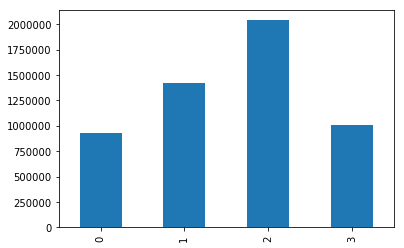

In [16]:
res['quarter'].value_counts().sort_index().plot('bar',sort_columns=True)

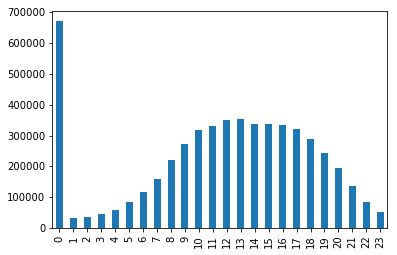

In [17]:
res['hours'].value_counts().sort_index().plot('bar',sort_columns=True)

Строим графики доходов и расходов относительно пола

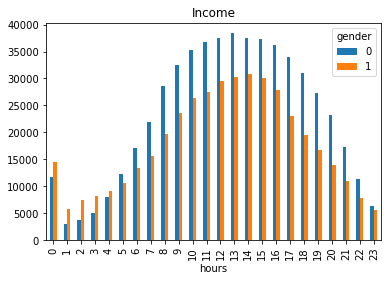

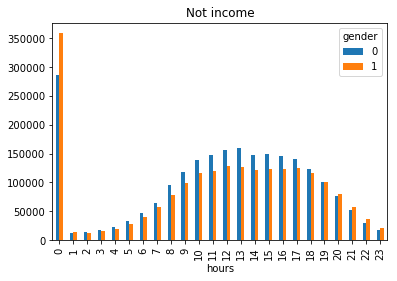

In [18]:
income = res[res['income']==True]
not_income = res[res['income']==False]
pd.crosstab(income['hours'],income['gender']).plot(kind='bar', stacked = False, title='Income')
pd.crosstab(not_income['hours'],not_income['gender']).plot(kind='bar', stacked = False, title='Not income')




In [19]:
res.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,mcc_description,date,weekday,day,time,hours,quarter,income
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих...",0,4,0,10:23:26,10,1,0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,1,5,1,10:19:29,10,1,1
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,Списание с карты по операции “перевода с карты...,Денежные переводы,1,5,1,10:20:56,10,1,0
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",1,5,1,10:39:54,10,1,0
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",2,6,2,15:33:42,15,2,0


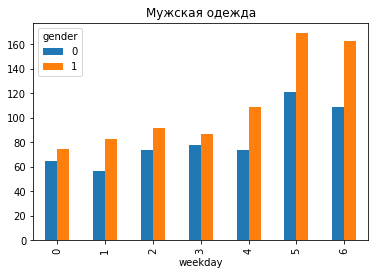

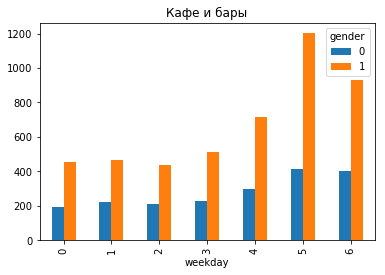

In [20]:
food_clear_payments = res[res['mcc_code']==5611] #транзакции по покупкам мужской одежды
pd.crosstab(food_clear_payments['weekday'],food_clear_payments['gender']).plot(kind='bar', stacked = False, title='Мужская одежда')
food_clear_payments = res[res['mcc_code']==5813] #транзакции по покупкам в барах
pd.crosstab(food_clear_payments['weekday'],food_clear_payments['gender']).plot(kind='bar', stacked = False, title='Кафе и бары')

Предполагаем, что weekday = 5,6 - выходные

Найдем начало года

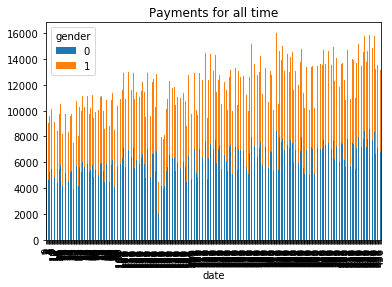

In [21]:
pd.crosstab(res['date'],res['gender']).plot(kind='bar', stacked = True, title='Payments for all time')

Резкий спад на графике объясняется первым января. Найдем порядковый номер этого дня в датасете.

In [22]:
pd.crosstab(res['date'],res['gender']).sort_values(by=[0,1]).head()

gender,0,1
date,,
153,2008,2437
154,3071,3259
155,3334,3537
16,3576,3374
2,3623,3337


Следовательно, 1 января - день № 153.

Приблизительно определим месяц транзакции

In [23]:
res['month'] = res['date'].apply(lambda s: int(((s + (365-153)) % 365)/(365/12)))
res['year'] = res['date'].apply(lambda s: int((s + (365-153)) / 365))
res['month_order'] = res['date'].apply(lambda s: int(((s + (365-153)))/(365/12)))
res.head()


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,mcc_description,date,weekday,day,time,hours,quarter,income,month,year,month_order
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1,Оплата услуги. Банкоматы СБ РФ,"Звонки с использованием телефонов, считывающих...",0,4,0,10:23:26,10,1,0,6,0,6
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,1,5,1,10:19:29,10,1,1,7,0,7
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,Списание с карты по операции “перевода с карты...,Денежные переводы,1,5,1,10:20:56,10,1,0,7,0,7
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",1,5,1,10:39:54,10,1,0,7,0,7
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1,Покупка. POS ТУ СБ РФ,"Различные продовольственные магазины — рынки, ...",2,6,2,15:33:42,15,2,0,7,0,7


<h2>Создание новых признаков</h2>

Соберем объем транзакций по месяцам

In [24]:
mcc_codes_list = codes['mcc_code'].unique()
valid_customer_ids = res['customer_id'].unique()
customers = customers_gender_train[customers_gender_train['customer_id'].apply(lambda s: s in valid_customer_ids)]
#отсеяли покупателей, которых нет в списке транзакций

vocab = {}
for item in res.iterrows():
#    print(item[1])
    customer_id = item[1]['customer_id']
    amount = item[1]['amount']
    mcc_type = item[1]['mcc_code']

    if(customer_id in vocab):
        if(mcc_type in vocab[customer_id]):
            if(amount<0):
                vocab[customer_id][mcc_type][0] = vocab[customer_id][mcc_type][0] + amount
            else:
                vocab[customer_id][mcc_type][1] = vocab[customer_id][mcc_type][1] + amount
        else:
            vocab[customer_id][mcc_type] = {0:0, 1:0}
            if(amount<0):
                vocab[customer_id][mcc_type][0] = amount
            else:
                vocab[customer_id][mcc_type][1] = amount
    else:
        vocab[customer_id]={}
        vocab[customer_id][mcc_type] = {0:0, 1:0}
        if(amount<0):
            vocab[customer_id][mcc_type][0] = amount
        else:
            vocab[customer_id][mcc_type][1] = amount
#создаем словарь вида {customer_id : {mcc_type: amount}}
    
def amount(s, item, i):
    if(s in vocab):
        if item in vocab[s]:
            return vocab[s][item][i]
    return 0

#добавляем сумму трат по каждой категории в датасет
for item in mcc_codes_list:
    customers['mcc_' + str(item)] = customers['customer_id'].apply(lambda s: amount(s,item,0))
customers.head()


,customer_id,gender,mcc_742,mcc_1711,mcc_1731,mcc_1799,mcc_2741,mcc_3000,mcc_3351,mcc_3501,...,mcc_8299,mcc_8398,mcc_8641,mcc_8699,mcc_8999,mcc_9211,mcc_9222,mcc_9311,mcc_9399,mcc_9402
0,75562265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
1,10928546,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-116883.30,0.0,0.0,0.0,-78157.87,0.0
2,69348468,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-4491.84,0.0,0.0,0.0,0.00,0.0
3,84816985,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
4,61009479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0


In [25]:
#формируем список всех категорий
mcc_cols = []
for item in mcc_codes_list:
    mcc_cols.append("mcc_" + str(item))

# all_payments - потраченная за весь период сумма
def f(x):
    s=0
    for item in mcc_cols:
        s+=x[item]
    return s

customers['all_payments'] = customers.apply(f, axis=1)
customers.head()

,customer_id,gender,mcc_742,mcc_1711,mcc_1731,mcc_1799,mcc_2741,mcc_3000,mcc_3351,mcc_3501,...,mcc_8398,mcc_8641,mcc_8699,mcc_8999,mcc_9211,mcc_9222,mcc_9311,mcc_9399,mcc_9402,all_payments
0,75562265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,-3.039319e+07
1,10928546,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-116883.30,0.0,0.0,0.0,-78157.87,0.0,-7.460927e+08
2,69348468,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-4491.84,0.0,0.0,0.0,0.00,0.0,-5.843229e+06
3,84816985,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,-4.135730e+05
4,61009479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,-5.581553e+06


In [26]:
feature_cols = mcc_cols
feature_cols.append('all_payments')

mid_income = customers['all_payments'].mean() # Вычисляем доход относительно остальных
customers['mean_all_payments'] = customers['all_payments'].apply(lambda s: s/mid_income)
feature_cols.append('mean_all_payments')
customers.head()

,customer_id,gender,mcc_742,mcc_1711,mcc_1731,mcc_1799,mcc_2741,mcc_3000,mcc_3351,mcc_3501,...,mcc_8641,mcc_8699,mcc_8999,mcc_9211,mcc_9222,mcc_9311,mcc_9399,mcc_9402,all_payments,mean_all_payments
0,75562265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,-3.039319e+07,1.334746
1,10928546,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-116883.30,0.0,0.0,0.0,-78157.87,0.0,-7.460927e+08,32.765379
2,69348468,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4491.84,0.0,0.0,0.0,0.00,0.0,-5.843229e+06,0.256611
3,84816985,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,-4.135730e+05,0.018162
4,61009479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,-5.581553e+06,0.245119


In [27]:
#вывод AUC-ROC кривой
from sklearn import  metrics
def show_auc(y_test, y_pred, color = 'b', text=''):
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color, label = text + ' AUC = %0.5f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

Обучаем Random Forest

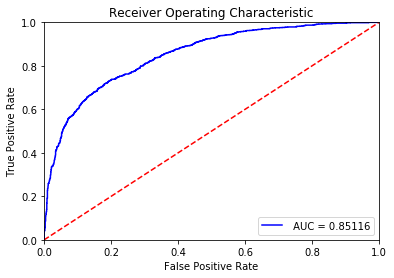

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(customers[feature_cols], customers['gender'], stratify=customers['gender'], random_state=43)
forest = RandomForestClassifier(n_estimators=500, random_state=24, max_depth=30, max_features=15)
forest.fit(X_train, y_train)
y_pred = forest.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred)

Соберем статистику трат по часам

In [29]:
customer_ids = customers['customer_id'].unique()
vocab = {}
for item in res.iterrows():
    customer_id = item[1]['customer_id']
    hour_val = item[1]['hours']
    income = item[1]['income']
    
    if(customer_id in vocab):
        if(income==0):
            vocab[customer_id][hour_val]+=1
    else:
        vocab[customer_id] = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0}
        if(income==0):
            vocab[customer_id][hour_val]+=1
def h(customer_id, time):
    return vocab[customer_id][time]

# Признак "i_h" - общее количество транзакций для  i-го часа
for i in range(24):
    customers[str(i)+ '_h'] = customers['customer_id'].apply(lambda s: h(s, i))
for i in range(24):
    feature_cols.append(str(i)+'_h')
customers.head()

,customer_id,gender,mcc_742,mcc_1711,mcc_1731,mcc_1799,mcc_2741,mcc_3000,mcc_3351,mcc_3501,...,14_h,15_h,16_h,17_h,18_h,19_h,20_h,21_h,22_h,23_h
0,75562265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,13,9,16,11,13,14,14,25,15
1,10928546,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55,61,39,21,12,6,5,3,1,0
2,69348468,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88,30,8,12,21,24,27,2,7,4
3,84816985,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,7,6,9,5,3,6,1,2,0
4,61009479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16,14,9,6,2,0,0,0,0,0


In [30]:
hours = []
for i in range(24):
    hours.append(str(i)+'_h')
    
def l(x):
    s=0
    for item in hours:
        s+=x[item]
    return int(s)
# Общее количество транзакций за период наблюдений
customers['transactions_count'] = customers.apply(l, axis=1)
customers.head()

,customer_id,gender,mcc_742,mcc_1711,mcc_1731,mcc_1799,mcc_2741,mcc_3000,mcc_3351,mcc_3501,...,15_h,16_h,17_h,18_h,19_h,20_h,21_h,22_h,23_h,transactions_count
0,75562265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,9,16,11,13,14,14,25,15,269
1,10928546,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61,39,21,12,6,5,3,1,0,702
2,69348468,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30,8,12,21,24,27,2,7,4,433
3,84816985,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,6,9,5,3,6,1,2,0,74
4,61009479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14,9,6,2,0,0,0,0,0,368


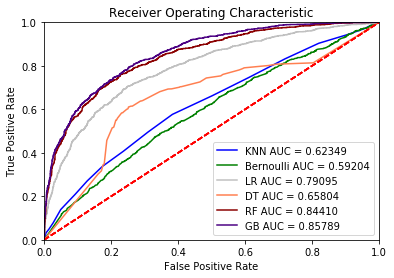

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(customers[feature_cols], customers['gender'], random_state=0)
def test_methods(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=25)
    knn.fit(X_train,y_train)
    y_pred = knn.predict_proba(X_test)[:,1]
    show_auc(y_test, y_pred, 'b', 'KNN')

    gauss = BernoulliNB()
    gauss.fit(X_train, y_train)
    y_pred = gauss.predict_proba(X_test)[:,1]
    show_auc(y_test, y_pred, 'g', 'Bernoulli')

    logreg = LogisticRegression(C=10)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict_proba(X_test)[:,1]
    show_auc(y_test, y_pred, 'silver', 'LR')

    tree = DecisionTreeClassifier(random_state=0, max_depth=15)
    tree.fit(X_train, y_train)
    y_pred = tree.predict_proba(X_test)[:,1]
    show_auc(y_test, y_pred, 'coral', 'DT')

    forest = RandomForestClassifier(n_estimators=300, random_state=24, max_depth=30, max_features=15)
    forest.fit(X_train, y_train)
    y_pred = forest.predict_proba(X_test)[:,1]
    show_auc(y_test, y_pred, 'darkred', 'RF')

    gbrt = GradientBoostingClassifier(random_state=0)
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict_proba(X_test)[:,1]
    show_auc(y_test, y_pred, 'indigo', 'GB')

test_methods(X_train, X_test, y_train, y_test)

Качество RF немного повысилось

In [32]:
vocab = {}
for item in res.iterrows():
#    print(item[1])
    customer_id = item[1]['customer_id']
    weekday = item[1]['weekday']
    income = item[1]['income']
    if(customer_id in vocab):
        if(income==0):
            if(weekday >= 5):
                vocab[customer_id]['weekend_count']+=1
            else:
                vocab[customer_id]['not_weekend_count']+=1
    else:
        vocab[customer_id] = {'weekend_count':0, 'not_weekend_count':0}
        if(income==0):
            if(weekday >= 5):
                vocab[customer_id]['weekend_count']+=1
            else:
                vocab[customer_id]['not_weekend_count']+=1

In [33]:
def h(customer_id, s):
    return vocab[customer_id][s]
customers['weekend_count'] = customers['customer_id'].apply(lambda s: vocab[s]['weekend_count'])
customers['not_weekend_count'] = customers['customer_id'].apply(lambda s: vocab[s]['not_weekend_count'])
def ratio(x):
    if((x['weekend_count']==0) or (x['not_weekend_count']==0)):
        return 0
    return x['weekend_count']/x['not_weekend_count']
customers['weekend_ratio'] = customers.apply(lambda s: ratio(s), axis=1)
feature_cols += ['weekend_count','not_weekend_count', 'weekend_ratio']
feature_cols = list(set(feature_cols))

Добавляем категориальный признак, обозначающий время суток, в которое совершается большее количество транзакций:

In [59]:
def top_time(x):
    lst = [0,0,0,0,0]
    for i in range(24):
        lst[int(i/5)] += x[str(i)+'_h']
    return lst.index(max(lst))
customers['top_time'] = c.apply(lambda s: top_time(s), axis=1)
customers.head()

,customer_id,gender,mcc_742,mcc_1711,mcc_1731,mcc_1799,mcc_2741,mcc_3000,mcc_3351,mcc_3501,...,19_h,20_h,21_h,22_h,23_h,transactions_count,weekend_count,not_weekend_count,weekend_ratio,top_time
0,75562265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,14,14,25,15,269,70,199,0.351759,4
1,10928546,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,5,3,1,0,702,146,556,0.262590,2
2,69348468,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,27,2,7,4,433,113,320,0.353125,2
3,84816985,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,6,1,2,0,74,17,57,0.298246,3
4,61009479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,368,90,278,0.323741,1


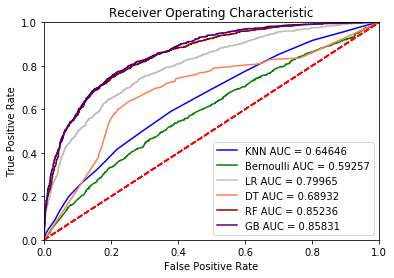

In [63]:
feature_cols.append('top_time')
feature_cols = list(set(feature_cols))
X_train, X_test, y_train, y_test = train_test_split(customers[feature_cols], customers['gender'], random_state=0, stratify=customers['gender'])
test_methods(X_train, X_test, y_train, y_test)


In [64]:
print(feature_cols)

['mcc_9399', 'mcc_4816', 'mcc_7512', 'mcc_4121', 'mcc_4789', 'mcc_5940', 'mcc_5714', 'mcc_5074', 'mcc_7278', 'mcc_5072', 'mcc_7994', 'mcc_5131', '11_h', 'mcc_5065', 'not_weekend_count', 'mcc_7298', 'mcc_7841', '13_h', 'mcc_7523', 'mcc_5411', 'mcc_8021', 'mcc_4111', 'mcc_7999', 'mcc_5085', '6_h', 'mcc_5211', 'mcc_5044', 'mcc_5977', 'mcc_5013', 'mcc_4784', 'mcc_5719', 'mcc_8043', 'mcc_9311', 'mcc_8220', 'mcc_5541', 'mcc_7375', '5_h', 'mcc_5099', 'mcc_7399', 'mcc_5969', 'mcc_7538', '12_h', 'mcc_5949', 'mcc_5943', 'mcc_5533', 'mcc_5094', 'mcc_7699', 'mcc_5812', 'mcc_7991', 'mcc_4722', 'mcc_6012', '18_h', 'mcc_5451', 'mcc_5944', 'mcc_3000', 'mcc_5571', 'mcc_5921', 'mcc_1799', 'mcc_4900', 'mcc_5813', 'mcc_5309', 'mcc_5948', 'mcc_7311', 'mcc_8699', 'mcc_5311', 'weekend_count', 'mcc_5499', 'mcc_5976', 'mcc_5511', 'mcc_5231', 'mcc_8062', 'mcc_7273', 'mcc_5137', 'mcc_5697', 'mcc_5816', 'mcc_5699', 'mcc_8641', 'mcc_7995', 'top_time', 'mcc_5734', 'mcc_5814', 'mcc_7997', 'mcc_4214', 'mcc_5122', 'mc

<h2><b>Нормализация</b></h2>

Тестирование без scaler'a

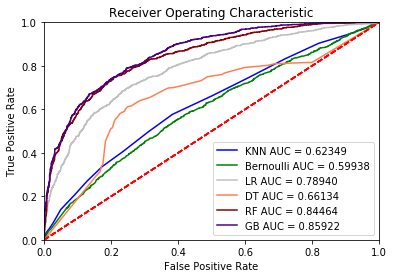

In [65]:
X_train, X_test, y_train, y_test = train_test_split(customers[feature_cols], customers['gender'], random_state=0)

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train,y_train)
y_pred = knn.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'b', 'KNN')

gauss = BernoulliNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'g', 'Bernoulli')

logreg = LogisticRegression(C=10)
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'silver', 'LR')

tree = DecisionTreeClassifier(random_state=0, max_depth=15)
tree.fit(X_train, y_train)
y_pred = tree.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'coral', 'DT')

forest = RandomForestClassifier(n_estimators=300, random_state=24, max_depth=30, max_features=15)
forest.fit(X_train, y_train)
y_pred = forest.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'darkred', 'RF')

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'indigo', 'GB')

Тестирование с min-max scaler'ом

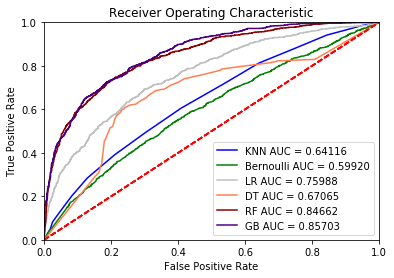

In [66]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'b', 'KNN')

gauss = BernoulliNB()
gauss.fit(X_train_scaled, y_train)
y_pred = gauss.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'g', 'Bernoulli')

logreg = LogisticRegression(C=10)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'silver', 'LR')

tree = DecisionTreeClassifier(random_state=0, max_depth=15)
tree.fit(X_train_scaled, y_train)
y_pred = tree.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'coral', 'DT')

forest = RandomForestClassifier(n_estimators=300, random_state=24, max_depth=30, max_features=15)
forest.fit(X_train_scaled, y_train)
y_pred = forest.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'darkred', 'RF')

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train_scaled, y_train)
y_pred = gbrt.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'indigo', 'GB')

RF стал работать хуже, GB - чуть лучше

Проверяем StandardScaler

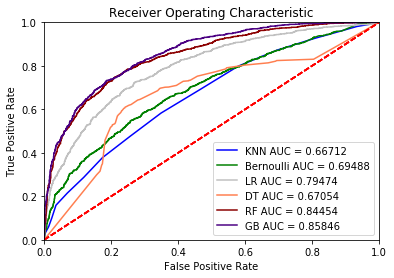

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'b', 'KNN')

gauss = BernoulliNB()
gauss.fit(X_train_scaled, y_train)
y_pred = gauss.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'g', 'Bernoulli')

logreg = LogisticRegression(C=10)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'silver', 'LR')

tree = DecisionTreeClassifier(random_state=0, max_depth=15)
tree.fit(X_train_scaled, y_train)
y_pred = tree.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'coral', 'DT')

forest = RandomForestClassifier(n_estimators=300, random_state=24, max_depth=30, max_features=15)
forest.fit(X_train_scaled, y_train)
y_pred = forest.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'darkred', 'RF')

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train_scaled, y_train)
y_pred = gbrt.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'indigo', 'GB')

RF - лучше, GB - хуже

Проверяем RobustScaler:

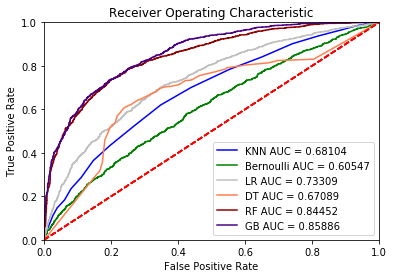

In [68]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'b', 'KNN')

gauss = BernoulliNB()
gauss.fit(X_train_scaled, y_train)
y_pred = gauss.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'g', 'Bernoulli')

logreg = LogisticRegression(C=10)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'silver', 'LR')

tree = DecisionTreeClassifier(random_state=0, max_depth=15)
tree.fit(X_train_scaled, y_train)
y_pred = tree.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'coral', 'DT')

forest = RandomForestClassifier(n_estimators=300, random_state=24, max_depth=30, max_features=15)
forest.fit(X_train_scaled, y_train)
y_pred = forest.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'darkred', 'RF')

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train_scaled, y_train)
y_pred = gbrt.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'indigo', 'GB')

RF - чуть лучше, GB - чуть хуже

<h2>XGBoost</h2>

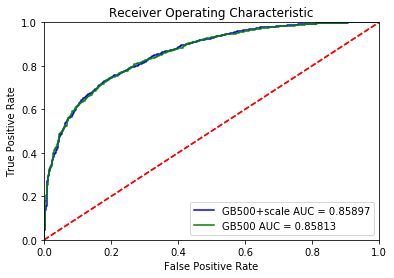

In [72]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_params1 = {'booster': 'gbtree', 'max_depth': 30, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': -1, 'eval_metric':'auc'}

bst = xgb.train(xgb_params1, xgb.DMatrix(X_train_scaled, label=y_train), num_boost_round=500)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)
y_pred = bst.predict(dtest)
show_auc(y_test, y_pred, 'blue', 'GB500+scale')

bst = xgb.train(xgb_params1, xgb.DMatrix(X_train, label=y_train), num_boost_round=500)
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = bst.predict(dtest)
show_auc(y_test, y_pred, 'green', 'GB500')



Определим важность каждого отдельного признака:

Axes(0.125,0.125;0.775x0.755)


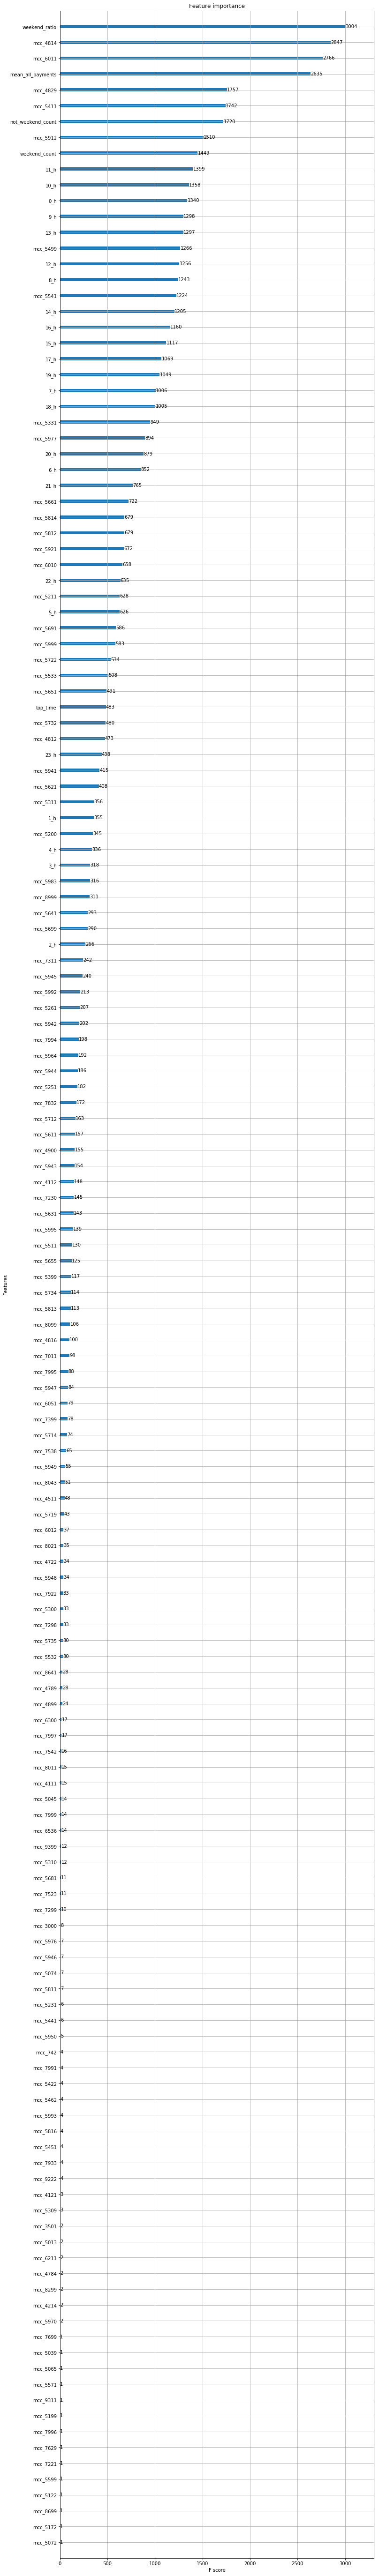

In [97]:
from xgboost import plot_importance
from matplotlib import pyplot
from pylab import rcParams
rcParams['figure.figsize'] = 12, 100

#plot_importance(bst)
#plt.show()
print(plot_importance(bst))


Видно, что высокий приоритет имеет weekend_ratio и mean_all_payments.
Добавим количество транзакций вечером пятницы:

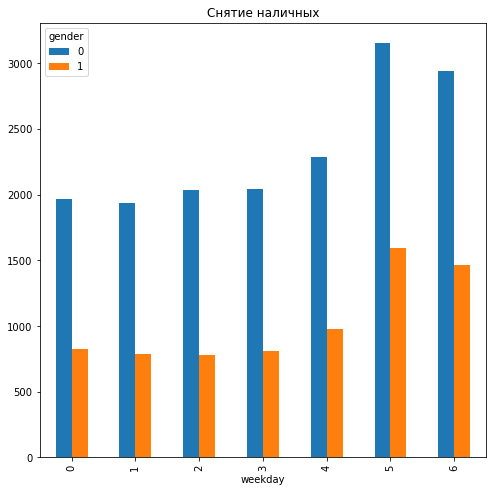

In [215]:
food_clear_payments = res[res['mcc_code']==5691] # 5411 - бакалея + супермаркеты, 0 преобладает
# 5912 - аптеки, 0 преобладает
pd.crosstab(food_clear_payments['weekday'],food_clear_payments['gender']).plot(kind='bar', stacked = False, title='Снятие наличных')




In [161]:
def mcc_info(mcc_code):
    transaction = codes[codes['mcc_code']==mcc_code]
    if(len(transaction)==0):
        print('invalid mcc_code')
    t = str(transaction['mcc_description'])
    print(t)



In [174]:
mcc_info(6011)

125    Финансовые институты — снятие наличности автом...
Name: mcc_description, dtype: object


In [223]:
def get_xgb_feat_importances(clf):
    if isinstance(clf, xgb.XGBModel):
        # clf has been created by calling
        # xgb.XGBClassifier.fit() or xgb.XGBRegressor().fit()
        fscore = clf.booster().get_fscore()
    else:
        # clf has been created by calling xgb.train.
        # Thus, clf is an instance of xgb.Booster.
        fscore = clf.get_fscore()
    feat_importances = []
    for ft, score in fscore.items():
        feat_importances.append({'Feature': ft, 'Importance': score})
    feat_importances = pd.DataFrame(feat_importances)
    feat_importances = feat_importances.sort_values(
        by='Importance', ascending=False).reset_index(drop=True)
    # Divide the importances by the sum of all importances
    # to get relative importances. By using relative importances
    # the sum of all importances will equal to 1, i.e.,
    # np.sum(feat_importances['importance']) == 1
    feat_importances['Importance'] /= feat_importances['Importance'].sum()
    return feat_importances
v = get_xgb_feat_importances(bst)

cols = v['Feature'][:110]

rcParams['figure.figsize'] = 8, 8

X_train, X_test, y_train, y_test = train_test_split(customers[cols], customers['gender'], random_state=0, stratify=customers['gender'])
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'indigo', 'GB')

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train_scaled, y_train)
y_pred = gbrt.predict_proba(X_test_scaled)[:,1]
show_auc(y_test, y_pred, 'darkred', 'GB scaled')

bst = xgb.train(xgb_params1, xgb.DMatrix(X_train_scaled, label=y_train), num_boost_round=500)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)
y_pred = bst.predict(dtest)
show_auc(y_test, y_pred, 'blue', 'GB500 scaled')

X_train, X_test, y_train, y_test = train_test_split(customers[feature_cols], customers['gender'], random_state=0, stratify=customers['gender'])
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict_proba(X_test)[:,1]
show_auc(y_test, y_pred, 'green', 'GB all')

KeyError: "['f0' 'f2' 'f3' 'f1' 'f5' 'f4' 'f7' 'f6' 'f11' 'f12' 'f8' 'f9' 'f15' 'f10'\n 'f14' 'f13' 'f16' 'f20' 'f18' 'f17' 'f21' 'f19' 'f23' 'f25' 'f24' 'f22'\n 'f27' 'f26' 'f31' 'f28' 'f29' 'f30' 'f38' 'f32' 'f33' 'f37' 'f34' 'f36'\n 'f35' 'f39' 'f40' 'f44' 'f41' 'f42' 'f46' 'f45' 'f47' 'f48' 'f43' 'f51'\n 'f50' 'f49' 'f52' 'f54' 'f56' 'f57' 'f53' 'f59' 'f58' 'f55' 'f61' 'f60'\n 'f63' 'f72' 'f62' 'f66' 'f71' 'f67' 'f68' 'f64' 'f76' 'f75' 'f65' 'f69'\n 'f70' 'f80' 'f82' 'f73' 'f79' 'f84' 'f81' 'f83' 'f74' 'f77' 'f78' 'f88'\n 'f90' 'f85' 'f86' 'f96' 'f91' 'f98' 'f100' 'f94' 'f89' 'f87' 'f95' 'f92'\n 'f102' 'f97' 'f93' 'f107' 'f118' 'f106' 'f105' 'f99' 'f119' 'f104' 'f103'\n 'f101'] not in index"

<h2><b>Снижение размерности</b></h2>

Для понижения размерности будем использовать RFE

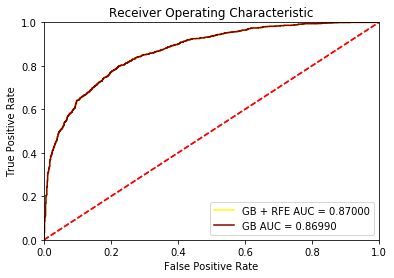

In [199]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
scaler = MinMaxScaler()
scaler.fit(X_train)
X_scale_train = scaler.transform(X_train)
X_scale_test = scaler.transform(X_test)

gbc = GradientBoostingClassifier(random_state=0)
rfe = RFE(gbc, 100) # если меньше - будет хуже 
rfe = rfe.fit(X_scale_train, y_train)
y_pred = rfe.predict_proba(X_scale_test)[:,1]
show_auc(y_test, y_pred, 'yellow', 'GB + RFE')

gbc2 = GradientBoostingClassifier(random_state=0) # Попробовать засунуть в pipeline
gbc2.fit(X_scale_train, y_train)
y_pred = gbc2.predict_proba(X_scale_test)[:,1]
show_auc(y_test, y_pred, 'darkred', 'GB')

In [227]:
print(rfe.get_support)

<bound method SelectorMixin.get_support of RFE(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
  n_features_to_select=100, step=1, verbose=0)>


In [214]:
print(feature_cols)

['21_h', '13_h', 'mcc_5968', 'mcc_5422', 'mcc_7999', 'mcc_5013', 'weekend_ratio', 'mcc_5511', 'mcc_5971', '1_h', 'mcc_5969', 'mcc_5976', 'mcc_5947', 'mcc_5261', 'mcc_5983', 'mcc_5499', 'mcc_5099', 'mcc_5074', 'mcc_6010', 'mcc_5921', 'mcc_5039', 'mcc_5542', 'mcc_7299', 'mcc_6211', '23_h', 'mcc_6513', 'mcc_6536', 'mcc_7375', 'mcc_7699', 'mcc_7399', 'mcc_5131', 'mcc_8398', 'mcc_7829', 'mcc_6300', 'mcc_4814', 'mcc_9402', 'mcc_5309', 'mcc_7278', 'mcc_5691', 'mcc_7997', 'mcc_5072', 'mcc_5655', '8_h', 'mcc_7338', 'mcc_5047', 'mcc_7995', 'mcc_5931', 'mcc_5942', 'mcc_5699', 'all_payments', 'mcc_5621', 'mcc_8043', '3_h', 'mcc_7512', 'mcc_5970', 'mcc_7991', 'mcc_3501', 'mcc_5094', 'mcc_5462', 'mcc_5172', 'mcc_1711', 'mcc_5137', 'mcc_7531', 'mcc_5812', '4_h', 'mcc_5571', 'mcc_5941', 'mcc_9222', 'mcc_4111', 'mcc_5714', 'mcc_7523', 'mcc_3351', 'mcc_4900', 'mcc_5311', 'mcc_5681', 'mcc_5712', 'mcc_5441', 'mcc_7011', 'mcc_5251', 'mcc_5734', 'mcc_5964', 'mcc_5192', 'mcc_5651', 'mcc_8220', 'mcc_8699', 'm

In [216]:
crop_feature_cols = []
for i in range(len(feature_cols)):
    if(rfe.ranking_[i] > 15):
        crop_feature_cols.append(feature_cols[i])
print(crop_feature_cols)

['mcc_5969', 'mcc_5947', 'mcc_5261', 'mcc_5099', 'mcc_5074', 'mcc_5542', 'mcc_7299', 'mcc_6211', 'mcc_6513', 'mcc_6536', 'mcc_7375', 'mcc_7699', 'mcc_8398', 'mcc_7829', 'mcc_6300', 'mcc_9402', 'mcc_5309', 'mcc_7278', 'mcc_7997', 'mcc_5072', 'mcc_7338', 'mcc_5047', 'mcc_5931', 'mcc_5942', 'mcc_8043', 'mcc_7512', 'mcc_5970', 'mcc_7991', 'mcc_5094', 'mcc_5462', 'mcc_5172', 'mcc_1711', 'mcc_5137', 'mcc_7531', 'mcc_5571', 'mcc_9222', 'mcc_7523', 'mcc_3351', 'mcc_5681', 'mcc_5712', 'mcc_5441', 'mcc_8220', 'mcc_8699', 'mcc_8011', 'mcc_4121', 'mcc_5451', 'mcc_5719', 'mcc_7395', 'mcc_5948', 'mcc_5995', 'mcc_7216', 'mcc_9311', 'mcc_4112', 'mcc_5085', 'mcc_4899', 'mcc_5044', 'mcc_7993', 'mcc_5200', 'mcc_5111', 'mcc_7996', 'mcc_8641', 'mcc_7221', 'mcc_7933', 'not_weekend_count', 'mcc_5944', '18_h', 'mcc_5994', 'mcc_5713', 'mcc_8244', 'mcc_9399', 'mcc_5399', 'mcc_5193', 'mcc_5733', 'mcc_5045', 'mcc_5199', 'mcc_5231', 'mcc_7542', 'mcc_4411', '19_h', 'mcc_1731', 'mcc_5993', 'mcc_7841', 'mcc_5940', 'm

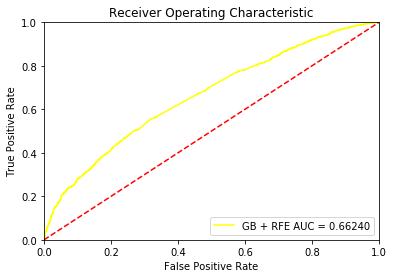

In [219]:
X_train, X_test, y_train, y_test = train_test_split(customers[crop_feature_cols], customers['gender'], random_state=0)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_scale_train = scaler.transform(X_train)
X_scale_test = scaler.transform(X_test)

gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_scale_train, y_train)
y_pred = gbc.predict_proba(X_scale_test)[:,1]
show_auc(y_test, y_pred, 'yellow', 'GB + RFE')




In [ ]:
# опоробовать PCA
# почитать про kbest и хи-квадрат
# 